In [1]:
# import the libraries
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, BatchNormalization, Dropout

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!7z x /content/drive/MyDrive/Claheclasses_1.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 268015777 bytes (256 MiB)

Extracting archive: /content/drive/MyDrive/Claheclasses_1.zip
 39% 4096 Open              --
Path = /content/drive/MyDrive/Claheclasses_1.zip
Type = zip
Physical Size = 268015777

  0%      4% 511 - Claheclasses_1/1/4086_left.jpeg                                            8% 855 - Claheclasses_1/1/1873_right.jpeg                                            10% 1158 - Claheclasses_1/1/3454_righ

In [4]:
import pathlib
data_dir = '/content/Claheclasses_1'
data_dir = pathlib.Path(data_dir)

In [6]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

10304


In [7]:
batch_size = 32
img_height = 299
img_width = 299

In [8]:
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle = True,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 10304 files belonging to 2 classes.


In [9]:
class_names = dataset.class_names
print(class_names)

['0', '1']


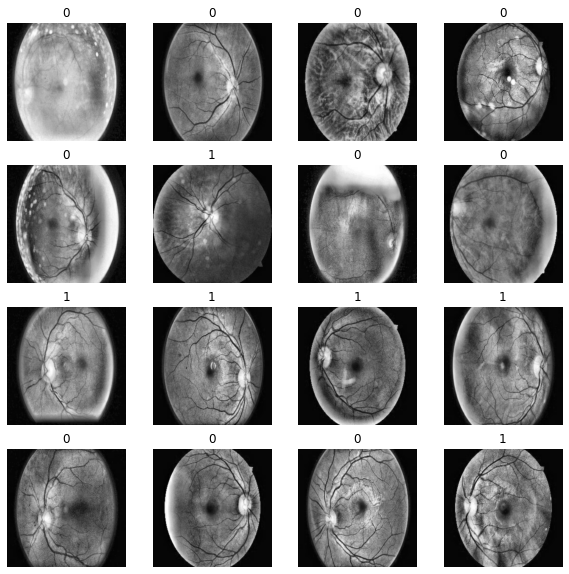

In [ ]:
plt.figure(figsize=(10, 10))
for images_batch, labels_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10304 files belonging to 2 classes.
Using 7213 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10304 files belonging to 2 classes.
Using 3091 files for validation.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.5, seed=None),
    layers.RandomCrop(150, 150, seed=None)
  ]
)

In [14]:
num_classes = len(class_names)

# Transfer Learning

In [15]:
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.models import Model

In [16]:
base_den = model = DenseNet201(weights='imagenet', include_top=False)
base_den.summary()

74836368/74836368 [==============================] - 0s 0us/step
Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                       

In [17]:
base_den.trainable = False

In [18]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_den(image_batch)
print(feature_batch.shape)

(32, 9, 9, 1920)


In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1920)


In [21]:
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


In [22]:
inputs = keras.Input(shape=(img_height, img_width, 3))
x = base_den(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.05)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [23]:
import time
start_cnn = time.time()

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

path = 'best_model_den.hdf5'
checkpoint = ModelCheckpoint(path, monitor='val_accuracy', verbose = 1, save_best_only = True, mode='max')
es = EarlyStopping(monitor='val_accuracy', patience=5)

callback_list = [checkpoint,es]

In [26]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callback_list  
)

Epoch 1/100
226/226 [==============================] - ETA: 0s - loss: 0.7491 - accuracy: 0.5260
Epoch 1: val_accuracy improved from -inf to 0.55451, saving model to best_model_den.hdf5
226/226 [==============================] - 103s 395ms/step - loss: 0.7491 - accuracy: 0.5260 - val_loss: 0.6919 - val_accuracy: 0.5545
Epoch 2/100
226/226 [==============================] - ETA: 0s - loss: 0.7094 - accuracy: 0.5655
Epoch 2: val_accuracy improved from 0.55451 to 0.57748, saving model to best_model_den.hdf5
226/226 [==============================] - 81s 359ms/step - loss: 0.7094 - accuracy: 0.5655 - val_loss: 0.6766 - val_accuracy: 0.5775
Epoch 3/100
226/226 [==============================] - ETA: 0s - loss: 0.7005 - accuracy: 0.5683
Epoch 3: val_accuracy did not improve from 0.57748
226/226 [==============================] - 81s 360ms/step - loss: 0.7005 - accuracy: 0.5683 - val_loss: 0.7465 - val_accuracy: 0.5180
Epoch 4/100
226/226 [==============================] - ETA: 0s - loss: 0.6

In [27]:
print("Total time: ", time.time() - start_cnn, "seconds")

Total time:  1289.6091327667236 seconds


In [28]:
scores = model.evaluate(train_ds)

226/226 [==============================] - 57s 253ms/step - loss: 0.6528 - accuracy: 0.6183


In [29]:
scores = model.evaluate(val_ds)

97/97 [==============================] - 25s 251ms/step - loss: 0.6957 - accuracy: 0.5930


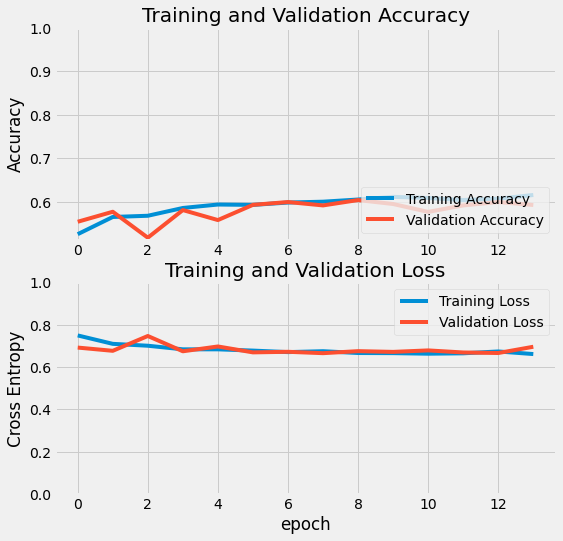

In [30]:
plt.style.use('fivethirtyeight')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [31]:
X = []
y = []
for image,labels in val_ds.take(75):
    for i in image:
        img = i.numpy()
        X.append(img)
    lbl_list = labels.numpy()    
    y.extend(lbl_list)   

In [32]:
x = np.array(X)

In [33]:
y = np.array(y)

In [34]:
x.shape, y.shape

((2400, 299, 299, 3), (2400,))

In [ ]:
model.evaluate(x[:2200],y[:2200])

69/69 [==============================] - 13s 159ms/step - loss: 0.5671 - accuracy: 0.7736


[0.5670700073242188, 0.7736363410949707]

In [35]:
from sklearn.metrics import confusion_matrix , classification_report
import numpy as np
y_pred = model.predict(x[:2400])
y_pred_classes = [np.argmax(element) for element in y_pred]
 
print("Classification Report: \n", classification_report(y[:2400], y_pred_classes))

75/75 [==============================] - 21s 244ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.57      0.85      0.69      1226
           1       0.69      0.34      0.45      1174

    accuracy                           0.60      2400
   macro avg       0.63      0.59      0.57      2400
weighted avg       0.63      0.60      0.57      2400

